# Mass spring damper demo
In this notebook we show how to model dynamic systems within the *dynsys_framework* and demonstrate the bootstrapping algorithm implemented in **Internal models with central pattern generator estimating and controlling gait dynamics**. The framework is demonstrated on [mass-spring-damper system](https://en.wikipedia.org/wiki/Mass-spring-damper_model) for which we must learn approximate model and infer the control policy.


## Mass-Spring-Damper model
Lets have an object of mass $m$ that moves on axis $x$. The object is linked to ground by string with stiffness $k$ and by damper with damper ratio $c$. The object is pushed by an external force $F_{external}$. This system is known as [mass-spring-damper](https://en.wikipedia.org/wiki/Mass-spring-damper_model) which is modelled with the following differential

$-kx - c\dot x + F_{external} = m\ddot x$

which we rewrite into first order differential

$
\dot x = v\\ 
\dot v = -\frac{k}{m} x - \frac{c}{m} v + u
$

where $u = \frac{F_{external}}{m}$ is rescaled external force.

We will now implement simulation of the mass-spring-damper.

In [43]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from dynsys_framework.execution_helpers.model_executor_parameters import ModelExecutorParameters
from utils import experiment_helpers
from utils import records


In [26]:
# Mass-Spring-Damper model


def mass_spring_damper_d(xv, u, k_param=2, c_param=1, m_param=5):
    xv_d = np.zeros((1,2))
    xv_d[0, 0] = xv[0, 1]
    xv_d[0, 1] = - (k_param/m_param) * xv[0, 0] - (c_param/m_param) * xv[0, 1] + u
    return xv_d

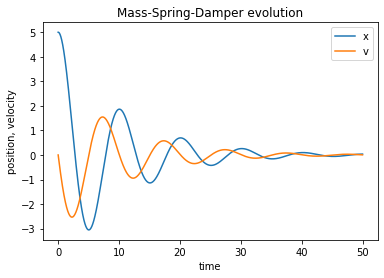

In [32]:
# Euler's method for numerical integration
step_size = 0.01
xvs = [np.asarray([5, 0]).reshape((1,2))]
ts = [0]
for i in range(5000):
    xvs.append(xvs[-1] + mass_spring_damper_d(xvs[-1], 0) * step_size)
    ts.append(ts[-1] + step_size)   
xvs = np.asarray(xvs)
ts = np.asarray(ts)

# plotting result    
plt.plot(ts, xvs[:, 0, 0], label="x")
plt.plot(ts, xvs[:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution")
plt.legend()
plt.show()

### DynSys Framework implementation
The above implemented Euler's method works fine; however, for more complex systems with tens of variables, the implementation would become cumbersome and the code would be hard to manage. In the following code snippets we will show, how the numerical integration is specified within the *dynsys_framework*.


In [39]:
step_size = 0.01
iterations = 5000
results_path = "results"

# 1. Creating the model composed of linearly growing time and the mass-spring-damper

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# variable "t" : Time 
mep.add("d_t", # name of the variable (with prefix "d_" because it is being numerically integrated)
        (), # the differential needs no inputs
        lambda: 1, # time grows proportionally to integration steps
        default_initial_values={"t": 0} # time starts at 0
       )

# variable "xv": Mass-spring-damper state 
mep.add("d_xv", # name of the variable
        ("xv", "u"), # the differential needs state "xv" and external force "u"
        mass_spring_damper_d, # function taking two inputs computing the differential 
        default_initial_values={"xv": np.asarray([5, 0]).reshape((1,2))} # initial state
       )

# variable "u": external force (is a constant zero)
mep.add("u", # name of the variable, note since it is not differential it has no "d_" prefix.
        (), # no inputs needed
        lambda: 0. # its value is always zero
       )


# 2. Execution initialization
mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_run")

iter: 0, t: 0, cmp_time: 0.00026226043701171875
iter: 1000, t: 9.999999999999831, cmp_time: 0.05403923988342285
iter: 2000, t: 20.000000000000327, cmp_time: 0.03785109519958496
iter: 3000, t: 30.00000000000189, cmp_time: 0.0367131233215332
iter: 4000, t: 40.00000000000061, cmp_time: 0.037439584732055664
time: 0.20287156105041504


In [46]:
# Reading the experiment results from "results/msd_run.hdf5"
rec = records.load_records(os.path.join(results_path, "msd_run.hdf5"))[0]

records.print_record_shapes(rec)
# See that all variables and their derivations are stored in the hdf5 file
# name          shape

d_t:          (5000,)
d_xv:          (5000, 1, 2)
t:          (5000,)
u:          (5000,)
xv:          (5000, 1, 2)


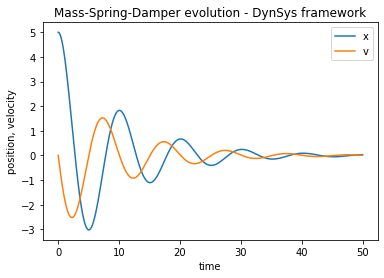

In [45]:
# the recorded variables are accessed by their names (rec is a python dictionary)
plt.plot(rec["t"], rec["xv"][:, 0, 0], label="x")
plt.plot(rec["t"], rec["xv"][:, 0, 1], label="v")
plt.xlabel("time")
plt.ylabel("position, velocity")
plt.title("Mass-Spring-Damper evolution - DynSys framework")
plt.legend()
plt.show()

## Goal-oriented bootstrapping of forward models
Lets say, that we have been given a repeating position trajectory $x^*(t)=x^*(t+T)$ which we want to observe on our mass-spring-damper $x^*(t) \approx x(t)$. We are able to command the external force $u$ and observe its position $x$. However, **we don't know the dynamic relation between external force $u$ and the observed position $x$**. 

This is where the proposed algorithm comes in. It is able to explore unknown dynamics and synthesise periodic command signal (gait) that produces the desired behavior $x^*$.

In [50]:
import models.limit_cycle_controller_contextual as M


step_size = 0.01
iterations = 5000
results_path = "results"

granularity = 8

mep = ModelExecutorParameters() # Contains set of all involved variables and their functors/differentials 

# MASS-SPRING-DAMPER
# variable "t" : Time 
mep.add("d_t", (), lambda: 1, default_initial_values={"t": 0})
# variable "xv": Mass-spring-damper state 
mep.add("d_xv", ("xv", "u"), mass_spring_damper_d, 
        default_initial_values={"xv": np.asarray([5, 0]).reshape((1,2))})
# variable "x_observed": observed position (taken from the mass-spring-damper state)
mep.add("x_observed", "xv", lambda xv: xv[0, 0])

# BOOTSTRAPPING CONTROLLER
# The set of variables
mep.add("u_regularization", (), lambda: 0.)
M.model(mep,
          epicycle_size=64, phase_velocity=4.,
          motor_dim=1, motor_segments_num=granularity,
          sensory_dim=1, sensory_segments_num=granularity,
          context_num=10,
          model_quality_lower_bound=1e0, model_quality_upper_bound=1e1,
          performance_quality_upper_bound=2e1,
          perturbation_probability=0.01,
          is_model_learned=True,
          is_control_learned=True, 
          is_model_lr_external=True,
          dynamic_outer_threshold=False,
          regularization_name="u_regularization"
          )

# COUPING THE BOOTSTRAPPING CONTROLLER WITH MASS-SPRING-DAMPER

# targets setup # TODO
mep.add(M.SENSORY_REFERENCE, "y_goal_setup", lambda y_goal: y_goal[:, :, :, :, 0])
mep.add(M.SENSORY_REFERENCE_MASK, "y_goal_setup", lambda y_goal: y_goal[:, :, :, :, 1])
mep.add(M.SENSORY_REFERENCE_MINMAX_MASK, "y_goal_setup", lambda y_goal: y_goal[:, :, :, :, 2])

# sensory input
mep.add(M.SENSORY_INPUT, "x_observed", lambda x: x)

# motor command
mep.add("u", M.MOTOR_COMMAND, lambda u: u)

# CPG setup
mep.add(M.MOTOR_PERTURBATION, (), lambda: 0)
mep.add(M.STATE_PERTURBATION, (), lambda: 0)

# 2. Execution initialization
#mod_exec = experiment_helpers.build_executor(mep, step_size)

# 3. Running the model simulation which will be saved into "results/msd_run.hdf5"
#experiment_helpers.run_executor(mod_exec, iterations, results_path, "msd_run")